In [1]:
!pip install pandas numpy xgboost rdkit streamlit-ketcher matplotlib tqdm requests


In [2]:
import pandas as pd
import numpy as np
import requests
import os
import xgboost as xgb
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve, 
    auc, 
    classification_report
)

tqdm.pandas()

# Configuration
DATASET_URL = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clintox.csv.gz"
MODEL_FILE = "tox_model.json"
FINGERPRINT_RADIUS = 2 
FINGERPRINT_BITS = 2048

### Data loading

In [3]:
def download_data():
    if not os.path.exists("clintox.csv.gz"):
        print(f"Downloading ClinTox dataset...")
        response = requests.get(DATASET_URL)
        with open("clintox.csv.gz", "wb") as f:
            f.write(response.content)
    else:
        print("Dataset already exists locally.")

download_data()
df = pd.read_csv("clintox.csv.gz")
df_clean = df.dropna(subset=['CT_TOX', 'smiles']).copy()

# Check Balance
num_toxic = df_clean['CT_TOX'].sum()
num_safe = len(df_clean) - num_toxic
print(f"Total: {len(df_clean)} | Toxic (1): {num_toxic} | Safe (0): {num_safe}")

Dataset already exists locally.
Total: 1484 | Toxic (1): 112 | Safe (0): 1372


### Feature engineering

In [4]:
def get_fingerprint(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # We use Bit Vectors (0s and 1s)
            # Updated to use rdMolDescriptors to avoid AllChem deprecation warnings
            fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=FINGERPRINT_RADIUS, nBits=FINGERPRINT_BITS)
            return list(fp)
    except:
        return None
    return None

print("Generating fingerprints... this may take 1-2 minutes.")
# Use progress_apply to see the loading bar
df_clean['features'] = df_clean['smiles'].progress_apply(get_fingerprint)

# Remove failed conversions
df_final = df_clean.dropna(subset=['features'])
print(f"Final training set size: {len(df_final)}")


Generating fingerprints... this may take 1-2 minutes.


  0%|          | 0/1484 [00:00<?, ?it/s]

[15:52:28] DEPRECATION WARNING: please use MorganGenerator
[15:52:28] DEPRECATION WARNING: please use MorganGenerator
[15:52:28] DEPRECATION WARNING: please use MorganGenerator
[15:52:28] DEPRECATION WARNING: please use MorganGenerator
[15:52:28] DEPRECATION WARNING: please use MorganGenerator
[15:52:28] DEPRECATION WARNING: please use MorganGenerator
[15:52:28] DEPRECATION WARNING: please use MorganGenerator
[15:52:28] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:52:28] DEPRECATION WARNING: please use MorganGenerator
[15:52:28] DEPRECATION WARNING: please use MorganGenerator
[15:52:28] DEPRECATION WARNING: please use MorganGenerator
[15:52:28] DEPRECATION WARNING: please use MorganGenerator
[15:52:28] DEPRECATION WARNING: please use MorganGenerator
[15:52:28] DEPRECATION WARNING: please use MorganGenerator
[15:52:28] DEPRECATION WARNING: please use MorganGenerator
[15:52:28] DEPRECATION WARNING: please use MorganGenerator
[15:52:28] DEPRECATION WARNING: please use

Final training set size: 1480


[15:52:32] DEPRECATION WARNING: please use MorganGenerator
[15:52:32] DEPRECATION WARNING: please use MorganGenerator
[15:52:32] DEPRECATION WARNING: please use MorganGenerator
[15:52:32] DEPRECATION WARNING: please use MorganGenerator
[15:52:32] DEPRECATION WARNING: please use MorganGenerator
[15:52:32] DEPRECATION WARNING: please use MorganGenerator
[15:52:32] DEPRECATION WARNING: please use MorganGenerator
[15:52:32] DEPRECATION WARNING: please use MorganGenerator
[15:52:32] DEPRECATION WARNING: please use MorganGenerator
[15:52:32] DEPRECATION WARNING: please use MorganGenerator
[15:52:32] DEPRECATION WARNING: please use MorganGenerator
[15:52:32] DEPRECATION WARNING: please use MorganGenerator
[15:52:32] DEPRECATION WARNING: please use MorganGenerator
[15:52:32] DEPRECATION WARNING: please use MorganGenerator
[15:52:32] DEPRECATION WARNING: please use MorganGenerator
[15:52:32] DEPRECATION WARNING: please use MorganGenerator
[15:52:32] DEPRECATION WARNING: please use MorganGenerat

In [5]:
print(df_final.head())
print(df_final.info())

                                              smiles  FDA_APPROVED  CT_TOX  \
0            *C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC             1       0   
1  [C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...             1       0   
2  [C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...             1       0   
3  [H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...             1       0   
4  [H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...             1       0   

                                            features  
0  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  
<class 'pandas.core.frame.DataFrame'>
Index: 1480 entries, 0 to 1483
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   smiles     

### Model Training: XGBoost

In [6]:
X = np.array(df_final['features'].tolist())
y = df_final['CT_TOX']

# 1. Split into Train (70%) and Temp (30%)
# stratify=y ensures we keep the same proportion of toxic drugs in all sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 2. Split Temp into Val (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training Shape: {X_train.shape}")
print(f"Validation Shape: {X_val.shape}")
print(f"Testing Shape: {X_test.shape}")

# Calculate scale_pos_weight based on Training data only
pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
print(f"Calculated scale_pos_weight: {pos_weight:.2f}")


Training Shape: (1036, 2048)
Validation Shape: (222, 2048)
Testing Shape: (222, 2048)
Calculated scale_pos_weight: 12.28


In [7]:
model = xgb.XGBClassifier(
    n_estimators=5000,         # give early stopping room
    max_depth=4,
    learning_rate=0.02,
    scale_pos_weight=pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    n_jobs=-1,
    eval_metric="aucpr",       # better because we have class imbalance
    early_stopping_rounds=50,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)


[0]	validation_0-aucpr:0.19245
[1]	validation_0-aucpr:0.21083
[2]	validation_0-aucpr:0.29111
[3]	validation_0-aucpr:0.22005
[4]	validation_0-aucpr:0.21906
[5]	validation_0-aucpr:0.24151
[6]	validation_0-aucpr:0.27319
[7]	validation_0-aucpr:0.29745
[8]	validation_0-aucpr:0.31263
[9]	validation_0-aucpr:0.31772
[10]	validation_0-aucpr:0.26815
[11]	validation_0-aucpr:0.30504
[12]	validation_0-aucpr:0.31183
[13]	validation_0-aucpr:0.36159
[14]	validation_0-aucpr:0.33277
[15]	validation_0-aucpr:0.31978
[16]	validation_0-aucpr:0.36637
[17]	validation_0-aucpr:0.37174
[18]	validation_0-aucpr:0.38591
[19]	validation_0-aucpr:0.38834
[20]	validation_0-aucpr:0.38008
[21]	validation_0-aucpr:0.38471
[22]	validation_0-aucpr:0.37810
[23]	validation_0-aucpr:0.37806
[24]	validation_0-aucpr:0.37361
[25]	validation_0-aucpr:0.38666
[26]	validation_0-aucpr:0.38657
[27]	validation_0-aucpr:0.38713
[28]	validation_0-aucpr:0.41195
[29]	validation_0-aucpr:0.41272
[30]	validation_0-aucpr:0.41291
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=5000,
              n_jobs=-1, num_parallel_tree=None, ...)

### Evaluate model


--- TEST SET EVALUATION ---
              precision    recall  f1-score   support

        Safe       0.98      0.79      0.87       205
       Toxic       0.23      0.76      0.36        17

    accuracy                           0.79       222
   macro avg       0.60      0.78      0.61       222
weighted avg       0.92      0.79      0.83       222



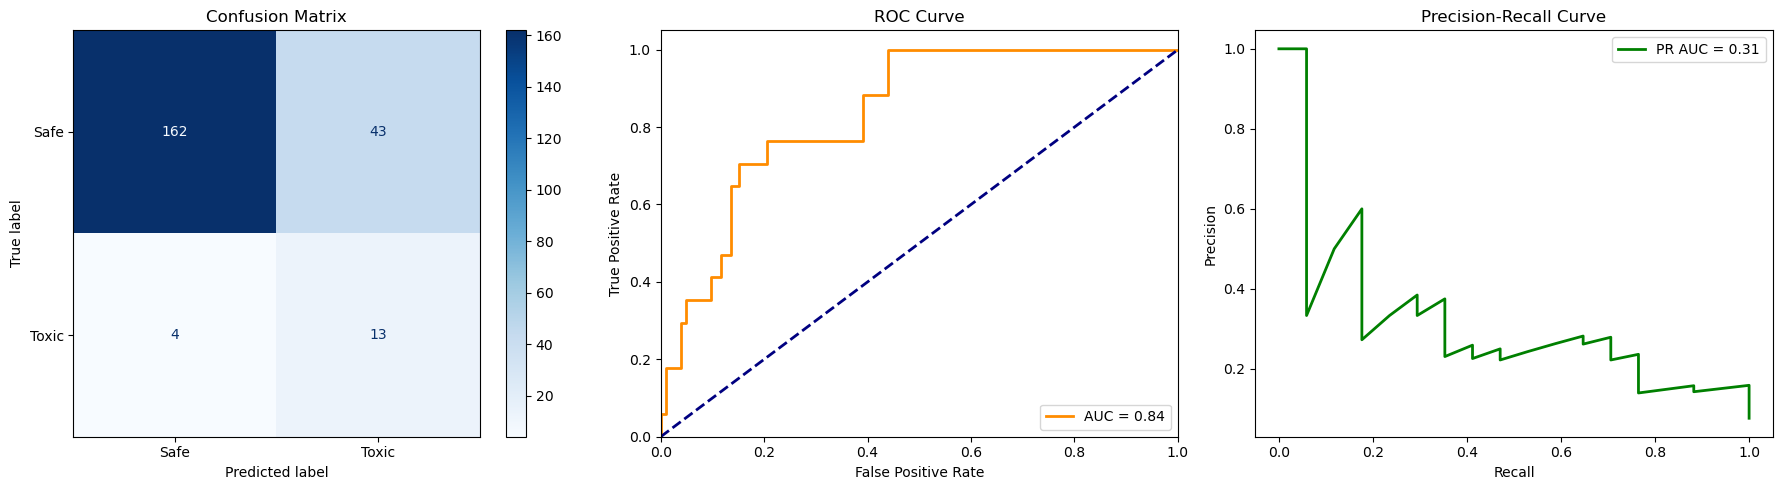

In [8]:
print("\n--- TEST SET EVALUATION ---")
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# 1. Classification Report
print(classification_report(y_test, y_pred, target_names=['Safe', 'Toxic']))

# 2. Plotting (Confusion Matrix, ROC, Precision-Recall)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Safe', 'Toxic'])
disp_cm.plot(ax=ax1, cmap='Blues')
ax1.set_title("Confusion Matrix")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend(loc="lower right")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
ax3.plot(recall, precision, color='green', lw=2, label=f'PR AUC = {pr_auc:.2f}')
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision-Recall Curve')
ax3.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [9]:
import numpy as np
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report

# Probabilities for the positive class (Toxic = 1)
p_val = model.predict_proba(X_val)[:, 1]

prec, rec, thr = precision_recall_curve(y_val, p_val)

target_recall = 0.85

# Indices where recall meets target
idx = np.where(rec >= target_recall)[0]

if len(idx) == 0:
    print("No threshold reaches the target recall on validation.")
else:
    # Choose the highest threshold that still achieves target recall
    i = idx[-1]
    chosen_thr = thr[i - 1] if i > 0 else 0.0

    print("Chosen threshold:", chosen_thr)
    print("Validation recall:", rec[i])
    print("Validation precision:", prec[i])

    y_val_pred = (p_val >= chosen_thr).astype(int)
    print("Validation confusion matrix:\n", confusion_matrix(y_val, y_val_pred))
    print(classification_report(y_val, y_val_pred, target_names=["Safe", "Toxic"]))


Chosen threshold: 0.41968802
Validation recall: 0.8823529411764706
Validation precision: 0.2
Validation confusion matrix:
 [[144  61]
 [  2  15]]
              precision    recall  f1-score   support

        Safe       0.99      0.70      0.82       205
       Toxic       0.20      0.88      0.32        17

    accuracy                           0.72       222
   macro avg       0.59      0.79      0.57       222
weighted avg       0.93      0.72      0.78       222



In [10]:
# Save the trained model to a JSON file
model.save_model("tox_model.json")

print("SUCCESS: Model saved as 'tox_model.json'")
print("IMPORTANT: Remember to use threshold = 0.42 in your app.py!")

SUCCESS: Model saved as 'tox_model.json'
IMPORTANT: Remember to use threshold = 0.42 in your app.py!


[16:00:26] DEPRECATION WARNING: please use MorganGenerator
[16:00:27] DEPRECATION WARNING: please use MorganGenerator


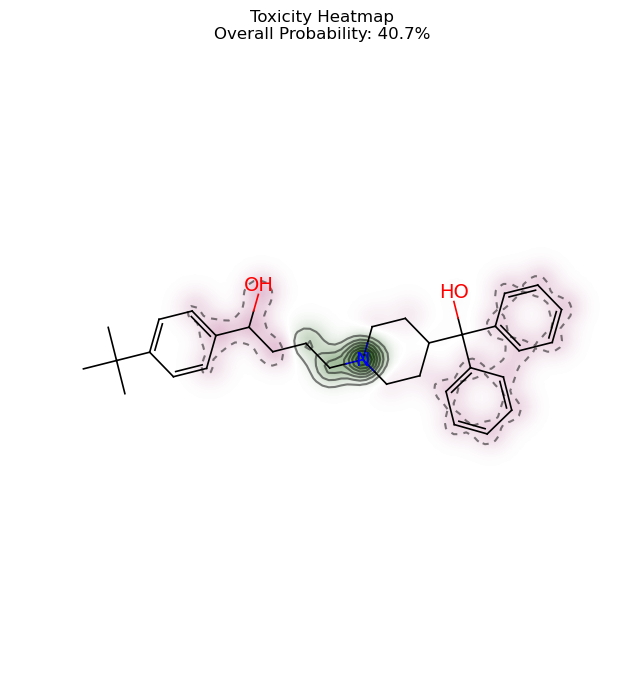

In [13]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps

# 1. Load your saved model
model = xgb.XGBClassifier()
model.load_model("tox_model.json")

# 2. Define the Wrapper Function
# This is crucial. RDKit 'SimilarityMaps' expects a function that takes a 
# single fingerprint and returns a single float (probability). 
# But XGBoost expects a 2D numpy array. This function bridges the gap.
def xgb_proba_wrapper(fingerprint):
    # Reshape the fingerprint to shape (1, 2048) for XGBoost
    fp_array = np.array(list(fingerprint)).reshape(1, -1)
    
    # Get the probability of Class 1 (Toxic)
    # [:, 1] gets the second column (probability of 1)
    prob = model.predict_proba(fp_array)[:, 1][0]
    return float(prob)

# 3. Choose a molecule to test
# Let's use Terfenadine (Known toxic/withdrawn drug)
# You can change this SMILES to anything else you want to test
smiles = "CC(C)(C)C1=CC=C(C=C1)C(O)CCCN2CCC(CC2)C(O)(C3=CC=CC=C3)C4=CC=CC=C4" 
mol = Chem.MolFromSmiles(smiles)

# 4. Generate the Map
# We let RDKit create the figure to avoid 'multiple values for ax' errors
# It automatically handles the canvas setup
fig = SimilarityMaps.GetSimilarityMapForModel(
    mol,
    lambda m, i: SimilarityMaps.GetMorganFingerprint(m, atomId=i, radius=2, nBits=2048, fpType='bv'),
    xgb_proba_wrapper
)

# 5. Add Interpretability Context
# Calculate the overall probability
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
overall_prob = xgb_proba_wrapper(fp)

plt.title(f"Toxicity Heatmap\nOverall Probability: {overall_prob:.1%}")
plt.show()